In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json 
from torch.utils.data import Dataset


# Load Test Examples
This dataset is too small to train on model on it but will serve as a test set 

In [17]:
path = "data/intent-detection-train.csv"
df = pd.read_csv(path)
df.head()

,text,label
0,Pouvez-vous me dire comment dire «je ne parle ...,translate
1,Dites-moi comment dire: «C'est une belle matin...,translate
2,"Si j'étais japonais, comment dirais-je que je ...",translate
3,Comment dire «hôtel» en finnois,translate
4,"J'ai besoin que vous traduisiez la phrase, «no...",translate


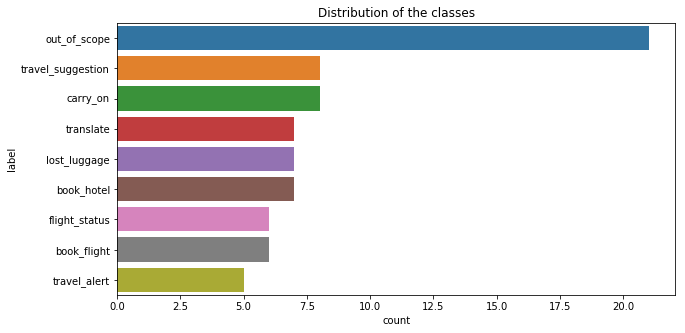

In [17]:
#make a nice horizontal bar plot of the distribution of the classes
plt.figure(figsize=(10,5))
sns.countplot(y="label", data=df, order=df.label.value_counts().index)
plt.title("Distribution of the classes")
plt.show()


In [21]:
from transformers import AutoTokenizer, \
                        AutoModelForSequenceClassification,\
                        BertTokenizer
from src.dataset import BertDataset

df = pd.read_csv(path)
prompts = df['text'].tolist()
intents = df['label'].tolist()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = BertDataset(prompts, intents, tokenizer, max_length=128)
dictionary = dataset.labels_dict
#revert the dictionary and save it to a json file
reverted_dict = {v: k for k, v in dictionary.items()}
print(reverted_dict)
with open('data/labels_dict.json', 'w') as fp:
    json.dump(reverted_dict, fp)


{0: 'travel_alert', 1: 'travel_suggestion', 2: 'book_hotel', 3: 'flight_status', 4: 'translate', 5: 'lost_luggage', 6: 'carry_on', 7: 'book_flight', 8: 'out_of_scope'}


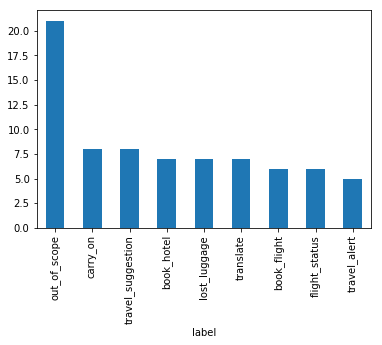

In [11]:
df.groupby('label').size().sort_values(ascending= False).plot(kind='bar')

Note that the dataset is unbalanced and the Out of Scope category is predominant. 

# Load Dataset 
After some research a heavily used dataset for intent classification is the CLINC150 dataset, it is used for evaluating the performance of intent classification in the presence of "out-of-scope" queries. 

Also the different labels in the test set are also present in the dataset, which is perfect for testing.

The dataset was downloaded from : https://github.com/clinc/oos-eval/tree/master/data

In [23]:
class CLNIC150(Dataset):
    def __init__(self, path, train = True):
        super().__init__()
        self.train= train
        self.path = path
        self.prompt, self.intent = self._read_clinc()

    def __len__(self):
        return len(self.prompt)
    
    def __getitem__(self, idx):
        return self.prompt[idx], self.intent[idx]
    
    def _read_clinc(self):

        #Load CLINC150 dataset from JSON file
        #Json from https://github.com/clinc/oos-eval/tree/master/data

        with open(self.path, 'r') as f:
            data = json.load(f)
        if self.train:
            data = data['train'] + data['oos_train']
        else:
            data = data['val'] + data['oos_val']

        prompt = []
        intent = [] 

        for row in data:
            prompt.append(row[0])
            intent.append(row[1])

        return prompt, intent

In [37]:
path_oosplus = "data/data_oos_plus.json"
path_full = "data/data_full.json"

clinc_train = CLNIC150(path_full, train = True)
clinc_test = CLNIC150(path_full, train = False)

clinc_train.__len__(), clinc_test.__len__()

(15100, 3100)

For purpose of exploration let's put it in dataframe

,prompts,intents
9684,bye now,goodbye
5457,"check the apr on my disney visa, please",apr
1214,i want to know when i was last paid,payday
4077,how is my credit score rated,credit_score
12631,i'd like to know what is on my shopping list,shopping_list


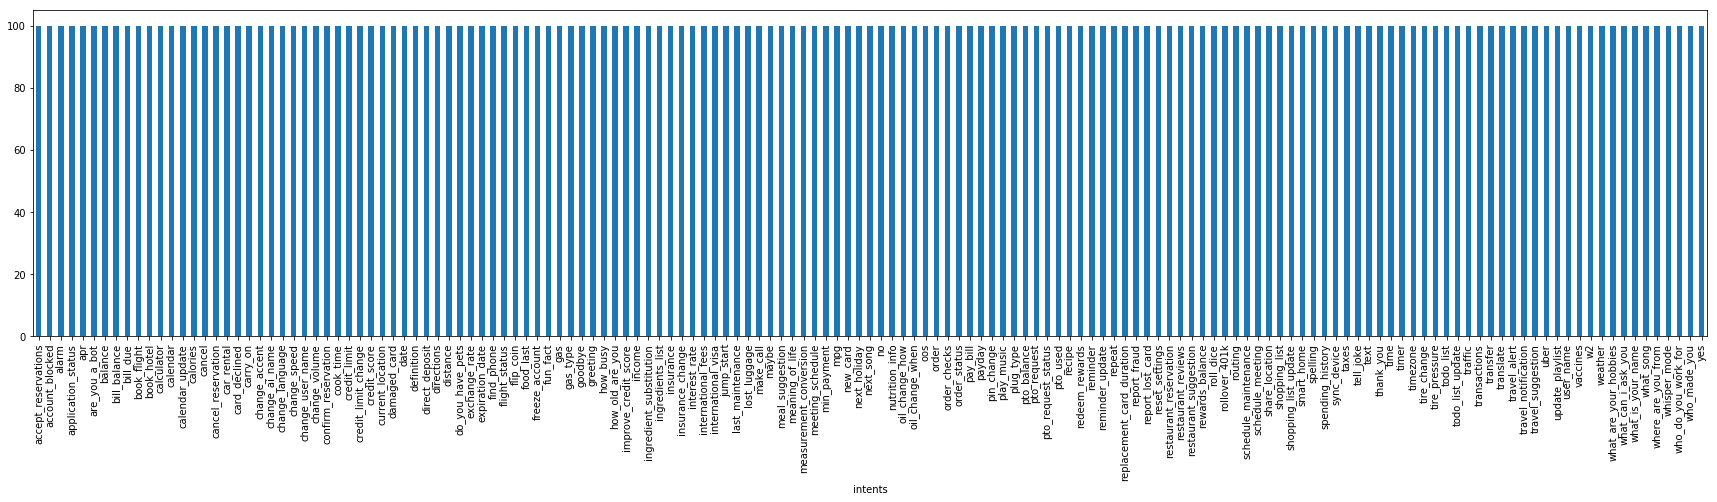

In [29]:
df_train = pd.DataFrame([clinc_train.prompt, clinc_train.intent]).T.rename(columns={0:'prompts', 1:'intents'})
df_test = pd.DataFrame([clinc_test.prompt, clinc_test.intent]).T.rename(columns={0:'prompts', 1:'intents'})
display(df_train.sample(5))

plt.figure(figsize=(30,6))
df_train.groupby('intents').size().plot(kind='bar')

In [50]:
df_train['intents'].unique().size

151

# Preprocessing

In [32]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugos\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
clinc_train.intent

In [87]:
from googletrans import Translator
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import nltk
import os

CLASSES_OF_INTEREST = [
    'translate',
    'travel_alert',
    'flight_status',
    'lost_luggage', # /!\ to this class
    'travel_suggestion',
    'carry_on',
    'book_flight',
    'book_hotel',
    'oos', # might be removed because a binary classification problem
]
class Preprocess:
    def __init__(self, bert = False):
        self.bert = bert

    def _lower(self, text):
        return text.lower()
    
    def _remove_punctuation(self, text):
        table = str.maketrans('', '', string.punctuation)
        return text.translate(table)
    
    def _translate(self, text):
        lang = detect(text)
        if lang != 'en':
            translator = Translator()
            text = translator.translate(text, dest='en', str = 'auto').text
        return text
    
    def _remove_stopwords(self, text):
        #Remove stopwords and perform stemming
        stemmer = PorterStemmer()

        nltk_path = 'data/nltk_data'
        if not os.path.exists(nltk_path):
            os.makedirs(nltk_path)
            nltk.download('stopwords', download_dir=nltk_path)

        cachedStopWords = stopwords.words("english")
        text = ' '.join([stemmer.stem(word) for word in text.split() if word not in cachedStopWords])
        return text

    def _tokenize(self, text):
        return nltk.word_tokenize(text)
    
    def _get_classes_of_interest(self, corpus : CLNIC150, classes_of_interest: list):
        #corpus.intent is a list 
        interest_index = []
        for i, intent in enumerate(corpus.intent):
            if intent in classes_of_interest:
                interest_index.append(i)

        corpus.intent = [corpus.intent[i] for i in interest_index]
        corpus.prompt = [corpus.prompt[i] for i in interest_index]
        return corpus
    
    def _preprocess(self, text):
        
        text = self._translate(text)
        text = self._lower(text)
        text = self._remove_punctuation(text)

        #don't remove stopwords if bert is used
        if not self.bert:
            text = self._remove_stopwords(text)

        return text

changed = clinc_train
preprocessor = Preprocess(bert= False)

preprocessor._preprocess("Pouvez-vous me dire comment dire «je ne parle pas beaucoup espagnol», en espagnol")
#new_corpus = preprocessor._get_classes_of_interest(changed, CLASSES_OF_INTEREST)



'tell say dont speak much spanish spanish'

In [4]:
!pip install --upgrade tqdm

  Using cached https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [15]:
from src.dataset import CLNIC150,BertDataset

path = 'data/data_oos_plus.json'
CLASSES_OF_INTEREST = [
    'translate',
    'travel_alert',
    'flight_status',
    'lost_luggage', # /!\ to this class
    'travel_suggestion',
    'carry_on',
    'book_flight',
    'book_hotel',
    'oos', # might be removed because a binary classification problem
]

clinc_train = CLNIC150(path, set= 'train')
x_train, y_train = clinc_train._get_classes_of_interest(classes_of_interest= CLASSES_OF_INTEREST)

clinc_val = CLNIC150(path, set= 'val')
x_val, y_val = clinc_val._get_classes_of_interest(classes_of_interest= CLASSES_OF_INTEREST)

In [2]:
from torch import nn
import torch
from sklearn.metrics import accuracy_score, classification_report

def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['intent'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['intent'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

def predict(text,model, tokenizer, device, max_length):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        return preds


In [3]:
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader

bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = BertDataset(x_train, y_train, tokenizer, max_length= 128)
val_dataset = BertDataset(x_val, y_val, tokenizer, max_length= 128)

train_loader = DataLoader(train_dataset, batch_size= 16, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= 16, shuffle= False)



In [4]:
from src.models import BERTClassifier
from transformers import get_linear_schedule_with_warmup

num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes = 9).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 2e-5)

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
import googletrans
googletrans.__version__

'3.1.0-alpha'

In [6]:

for epoch in range(num_epochs):
        train(model, train_loader, optimizer, scheduler, device)
        acc, report = evaluate(model, val_loader, device)
        print(f"Epoch: {epoch}, Accuracy: {acc}")
        print(report)

KeyboardInterrupt: 

In [21]:
from transformers import pipeline
from googletrans import Translator
from langdetect import detect

#to test : roberta-large-finetuned-clinc
#to test : bert-base-uncased
#to test : distilbert-base-uncased
#to test : vedantjumle/bert-clinc150-1

model_name = 'lewtun/roberta-large-finetuned-clinc'

classifier = pipeline("text-classification", model=model_name)

def _translate(text):
    lang = detect(text)
    if lang != 'en':
        translator = Translator()
        text = translator.translate(text, dest='en', str = 'auto').text
    return text

OSError: lewtun/roberta-large is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [20]:
prompt = "Ahhhh j'ai perdu mes bagages ! Je sais pas quoi faire ! C'est la première fois que ça m'arrive !"
classifier(_translate(prompt))

[{'label': 'lost_luggage', 'score': 0.970630943775177}]

In [3]:
data = 'data/intent-detection-train.csv'
model_name = 'lewtun/roberta-large-finetuned-clinc'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from src.dataset import BertDataset
import torch
def postprocess(label: str):

    classes_of_interest = [
        'translate',
        'travel_alert',
        'flight_status',
        'lost_luggage', # /!\ to this class
        'travel_suggestion',
        'carry_on',
        'book_flight',
        'book_hotel',
        'oos', # might be removed because a binary classification problem
        ]
    
    if label not in classes_of_interest:
        label = 'oos'
    if label == 'oos':
        label = 'out_of_scope'

    return label

def get_output(inputs: BertDataset, model):
    dataloader = torch.utils.data.DataLoader(inputs, batch_size=32, shuffle=True)
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            outputs = model(input_ids, attention_mask)

            best_output = outputs.logits.argmax(1).cpu().tolist()[0]

    best_output = model.config.id2label[best_output]
    best_output = postprocess(best_output)
    return best_output

from sklearn.metrics import classification_report

def evaluate_csv(csv, tokenizer, model):
    #Load a csv dataset contatining 'text' and 'label' columns
    df = pd.read_csv(csv)
    prompts = df['text'].tolist()
    intents = df['label'].tolist()

    predictions = []
    actual_labels = []

    for i, prompt in enumerate(prompts):
        to_dataset = BertDataset([prompt], [''], tokenizer, max_length = 128)
        output = get_output(to_dataset, model)
        label = intents[i]
        predictions.append(output)
        actual_labels.append(label)

    report = classification_report(actual_labels, predictions)
    print(report)

dataset = evaluate_csv(data, tokenizer, model)

                   precision    recall  f1-score   support

      book_flight       1.00      1.00      1.00         6
       book_hotel       1.00      1.00      1.00         7
         carry_on       1.00      0.88      0.93         8
    flight_status       0.86      1.00      0.92         6
     lost_luggage       1.00      1.00      1.00         7
     out_of_scope       0.91      0.95      0.93        21
        translate       1.00      1.00      1.00         7
     travel_alert       0.83      1.00      0.91         5
travel_suggestion       1.00      0.75      0.86         8

        micro avg       0.95      0.95      0.95        75
        macro avg       0.96      0.95      0.95        75
     weighted avg       0.95      0.95      0.95        75



In [10]:
from src.dataset import CLNIC150,BertDataset

path


'tell me how to say “it’s a beautiful morning” in italian'